## A model for activation-based sequence replay in a neural network

The goal of this project is to explore an activation-based model (i.e., with no synaptic plasticity) for how a neural network could remember and recall an activity pattern after only "hearing" it a single time. Replay of this sort is highly relevant to remembering a stimulus that is only presented once.

To implement this network I am using a rate-based model in which each unit (e.g., population of neurons) is governed by the following equations:

$\tau_i\cfrac{dv_i}{dt} = -v + v^i_{rest} + \sum_j W_{ij}r_j(t) + d^i_{drive}(t) + \eta(t)$,

$r_j(t) = \cfrac{1}{1 + \exp(-g[v_j(t) - v_{th}])}$.

where $\tau_i$ is unit $i$'s integration time, $v^i_{rest}$ is the $i$th unit's resting potential, $W$ is a connection weight matrix, $d^i_{drive}(t)$ is the drive to unit $i$ at time $t$, $\eta(t)$ is Gaussian noise, and $g$ and $v_{th}$ are parameters of the transfer function from voltage $v$ to firing rate $r$. All of this is fairly typical.

Note that $W_{ij}$ is the connection to unit $i$ from unit $j$.

### Basic architecture

This model is fundamentally based on the idea that the memory of a sequence is stored in long time-scale recurrent activity. It is composed of five different types of units, and each unit type is defined by its timescale, its resting potential, and its connectivity pattern. The five types of units are:

* "Fast" excitatory unit - one of the units involved in sequence (both in original presentation and in the replay)
* Inhibitory unit - provides uniform inhibition to fast units (only one inhibitory unit in network)
* "Switch" unit - provides global excitation necessary for  fast units to become spontaneously active
* Slow units (these comprise two subtypes):
  * Memory unit - unit whose activation encodes  recent sequential/simultaneous activation of a particular pair of fast units (there is one memory unit for each distinct pair of fast units)
  * Conduit unit - allows unidirectional communication from one fast unit to another; however, only if also receiving input from a memory unit connected to those two fast units
  
The general idea behind this architecture is that the fast units and inhibitory unit form a spontaneously active winner-take-all network, and the slow units act as mock synapses, enhancing connections between arbitrary pairs of fast units upon recent activation.

### Current progress: activation-based recall of associative memories in semi-spontaneously active WTA network

In the following example, I demonstrate the ability of a network with the above architecture to remember an association and recall it. Specifically, externally driving the red and black fast units sequentially causes the network to remember the red-black association. Then, during spontaneous activity, which is turned on about half-way through the trial (via activation of the switch unit), driving the red unit causes the black unit to respond and driving the black unit causes the red unit to respond, even though $W$ has not been altered.

In [3]:
%matplotlib inline
from figures import wta_memory_combo_basic

### Parameters for neurons, connections, noise, external drive, visualization

In [7]:
CONFIG = {
    'SEED': None,
    
    # unit parameters
    'TAU': 3,  # default integration timescale
    'TAU_M': 25,  # integration timescale of memory units
    'TAU_C': 15,  # integration timescale of conduit units
    'V_TH': 4,  # voltage threshold in firing rate relation
    'STEEPNESS': 2.5,  # steepness of rate/voltage relation
    'V_REST': 0,  # default resting voltage
    'V_REST_C': -10,  # resting voltage for conduit units (note: this could also be implemented via tonic inhibition)
    
    # weight matrix parameters
    'W_IF': 8,  # to inhibitory from "fast"
    'W_FS': 2.5,  # to fast from "switch"
    'W_FI': -6.5,  # to fast from inhibitory
    'W_FF': 8.,  # fast self-excitation
    'W_FC': 5.5,  # to fast from conduit
    'W_MF': 7,  # to memory from fast
    'W_MM': 6.5,  # memory self-excitation
    'W_CF': 9,  # to conduit from fast
    'W_CM': 10,  # to conduit from memory

    'N_UNITS': 6,  # number of fast units (these are the ones in which the memory is exhibited)
    
    'NOISE_LEVEL': 1,  # std of gaussian noise added to all units' voltage
    'S_DRIVE_AMP': 10,  # drive to switching unit
    'F1_DRIVE_AMP': 15,  # drive to fast unit 1 (red)
    'F0_DRIVE_AMP': 15,  # drive to fast unit 0 (black)
    
    'T_F1_DRIVE': 50,  # first start time of fast unit 1 drive (first red)
    'D_F1_DRIVE': 10,  # first duration of fast unit 1 drive
    'T_F0_DRIVE': 75,  # first start time of fast unit 0 drive (first black)
    'D_F0_DRIVE': 10,  # first duration of fast unit 0 drive
    'T2_F1_DRIVE': 250,  # second start time of fast unit 1 drive (second red)
    'D2_F1_DRIVE': 6,  # second duration of fast unit 1 drive
    'T2_F0_DRIVE': 350,  # second start time of fast unit 0 drive (second black)
    'D2_F0_DRIVE': 6,  # second duration of fast unit 0 drive
    'T_S_DRIVE': 150,  # start time of switch drive (which moves the network into its spontaneously active mode)
    'DURATION': 500,  # total simulation time
    
    'FONT_SIZE': 20,
    'COLOR_CYCLE': [
             [0, 0, 0],  # black
             [1, 0, 0],  # red
             [0, 1, 0],  # green
             [0, 0, 1],  # blue
             [1, 1, 0],  # yellow
             [1, 0, 1],  # magenta
             [0, 1, 1],  # cyan
             [.5, 0, 0],  # dark red
             [0, .5, 0],  # dark green
             [0, 0, .5],  # dark blue
        ],
}

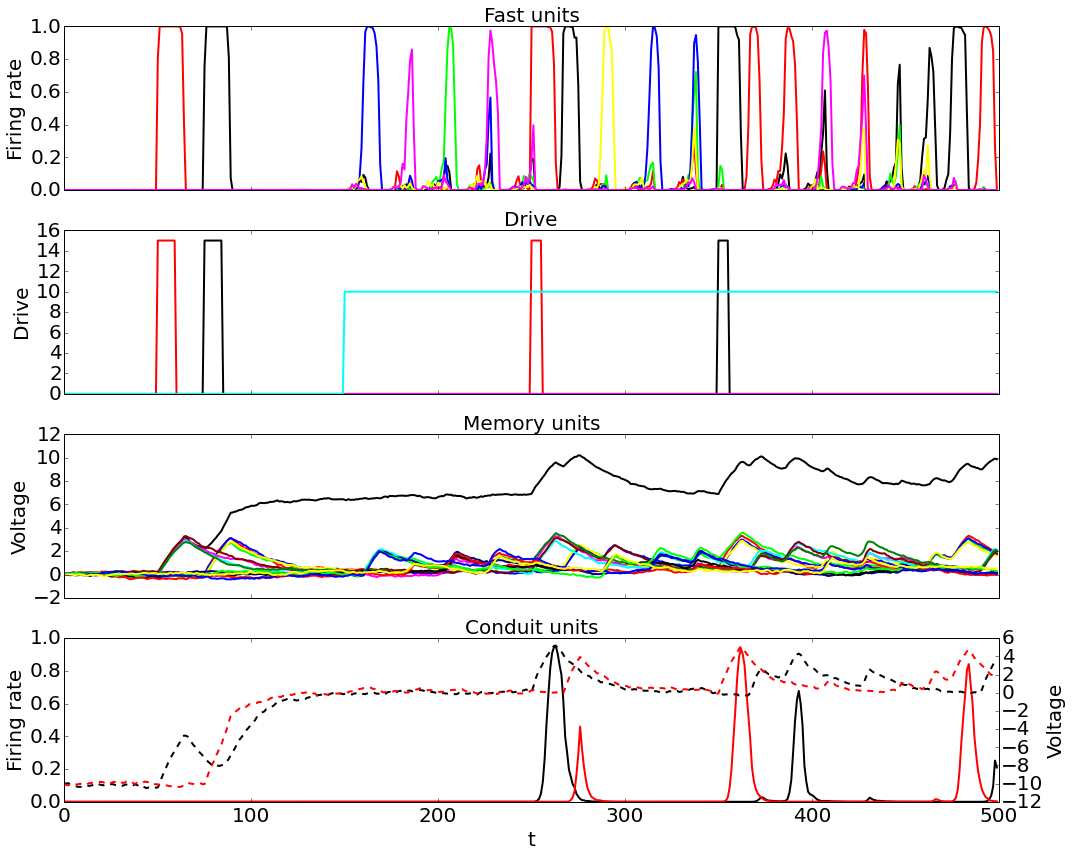

In [18]:
wta_memory_combo_basic.main(CONFIG)

### Figure explanation

* External inputs shown in 2nd row
  * Red and black = inputs to fast units
  * Cyan = input to switch (comes on at $t=150$)

* Fast unit firing rates shown in 1st row
  * Red and black fast units follow initial red and black drive
  * Spontaneous activity in fast units starts after switch is activated ($t=150$)
  * Spontaneous activity is fairly random and more or less follows WTA rule: only one fast unit active at a time
  * When red unit is driven ($t=250$), black unit subsequently activates
  * When black unit is driven ($t=350$), red unit subsequently activates
  * There is even spontaneous activation of the red-black association around $t=480$

* Memory units shown in 3rd row
  * Red-black memory unit (black trace) enters up-state after sequential activation of red and black fast units
  * This upstate is caused by an excitatory self-connection (representing strong recurrence in the population)
  * Notice that all red-something memory units respond transiently after fast red unit activation, but only red-black memory unit enters up-state, since it is the only one that receives input from red and black fast units

* Conduit units shown in 4th row
  * Only red->black (black trace) and black->red (red trace) conduit units shown
  * After red-black memory unit enters up-state, red->black and black->red conduit units enter up-state also
  * Conduit unit upstate, however, is not caused by self-connection, but rather input from red-black memory unit
  * Conduit units can only cross their threshold (indicated by firing rate being nonzero) when they receive input from memory unit
    * After red-black memory unit is activated, conduit units are activated by fast units enough to start firing
    * E.g., when red fast unit is driven at $t=250$, red->black conduit unit activates, subsequently activating black fast unit

* Thus: red-black memory unit + red->black and black->red conduit units form "mock synapse" between red and black fast units
* This forms an effective communication channel between red and black fast units that is modulated by their previous activations